In [ ]:
# Installing libraries if not already installed


# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:

data_path = "mtsamples.csv"
df = pd.read_csv(data_path)

# Basic info
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns)
df.head()


Shape of dataset: (4999, 6)

Columns:
 Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


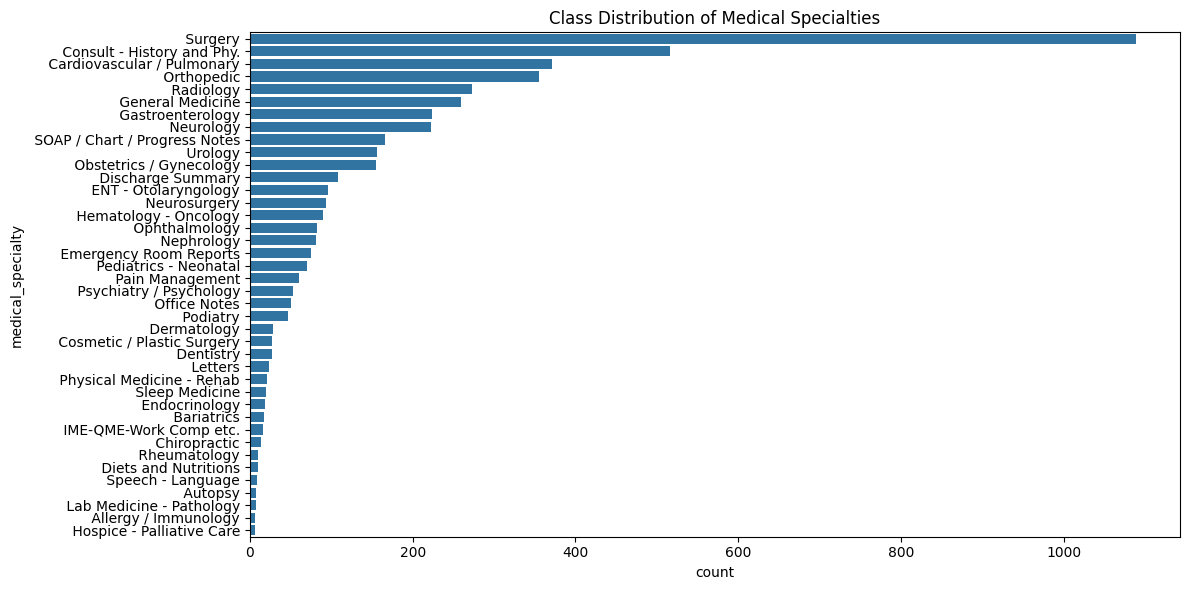

In [ ]:
# Checking for nulls
print(df.isnull().sum())

# Dropping rows with missing transcription or category
df = df.dropna(subset=["transcription", "medical_specialty"])

# Seeing class distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='medical_specialty', data=df, order=df['medical_specialty'].value_counts().index)
plt.title('Class Distribution of Medical Specialties')
plt.tight_layout()
plt.show()


#  Preprocessing 

In [ ]:
import re
import nltk
from sklearn.preprocessing import LabelEncoder

# Downloading NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


In [ ]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\n', ' ', text)  # Removing newlines
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Removing punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Removing extra spaces
    return text

df['clean_transcription'] = df['transcription'].apply(clean_text)
df['clean_transcription'].head()


0    subjective this yearold white female presents ...
1    past medical history he has difficulty climbin...
2    history of present illness i have seen abc tod...
3    d mmode left atrial enlargement with left atri...
4    the left ventricular cavity size and wall thic...
Name: clean_transcription, dtype: object

In [11]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_transcription'] = df['clean_transcription'].apply(remove_stopwords)


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['medical_specialty'])

# Mapping back to see label names
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:\n", label_mapping)

df[['medical_specialty', 'label']].drop_duplicates().sort_values('label').head()


Label Mapping:
 {' Allergy / Immunology': np.int64(0), ' Autopsy': np.int64(1), ' Bariatrics': np.int64(2), ' Cardiovascular / Pulmonary': np.int64(3), ' Chiropractic': np.int64(4), ' Consult - History and Phy.': np.int64(5), ' Cosmetic / Plastic Surgery': np.int64(6), ' Dentistry': np.int64(7), ' Dermatology': np.int64(8), ' Diets and Nutritions': np.int64(9), ' Discharge Summary': np.int64(10), ' ENT - Otolaryngology': np.int64(11), ' Emergency Room Reports': np.int64(12), ' Endocrinology': np.int64(13), ' Gastroenterology': np.int64(14), ' General Medicine': np.int64(15), ' Hematology - Oncology': np.int64(16), ' Hospice - Palliative Care': np.int64(17), ' IME-QME-Work Comp etc.': np.int64(18), ' Lab Medicine - Pathology': np.int64(19), ' Letters': np.int64(20), ' Nephrology': np.int64(21), ' Neurology': np.int64(22), ' Neurosurgery': np.int64(23), ' Obstetrics / Gynecology': np.int64(24), ' Office Notes': np.int64(25), ' Ophthalmology': np.int64(26), ' Orthopedic': np.int64(27), ' 

,medical_specialty,label
0,Allergy / Immunology,0
4981,Autopsy,1
1,Bariatrics,2
3,Cardiovascular / Pulmonary,3
4596,Chiropractic,4


# TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_transcription'])
y = df['label']

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (4966, 5000)


# BERT Embeddings (DistilBERT)

In [14]:
#!pip install transformers
#!pip install torch


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from tqdm import tqdm


In [ ]:

# Loading tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')


In [ ]:
# Subsample for speed 
sample_df = df.sample(n=2000, random_state=42).reset_index(drop=True)

def get_bert_embeddings(text_list):
    embeddings = []
    for text in tqdm(text_list):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embedding.squeeze().numpy())
    return np.array(embeddings)

X_bert = get_bert_embeddings(sample_df['clean_transcription'].tolist())
y_bert = sample_df['label'].values

print("BERT Embedding Shape:", X_bert.shape)


100%|██████████| 2000/2000 [01:01<00:00, 32.60it/s]


BERT Embedding Shape: (2000, 768)


# Model Training & Evaluation

# Logistic Regression (on TF-IDF)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:


# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Training Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predicting and Evaluate
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7325
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         9
           2       0.90      0.82      0.86        11
           3       0.56      0.90      0.69        10
           4       0.85      0.92      0.88        12
           5       0.00      0.00      0.00        13
           6       0.64      0.75      0.69        12
           7       0.89      1.00      0.94         8
           8       1.00      1.00      1.00        11
           9       0.89      1.00      0.94         8
          10       0.89      0.73      0.80        11
          11       1.00      0.62      0.77        16
          12       0.20      0.75      0.32         4
          13       0.80      0.89      0.84         9
          14       0.64      0.58      0.61        12
          15       0.15      0.33      0.21         6
          16       0

# Random Forest (on TF-IDF)

In [44]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:

# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting and Evaluating
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6975
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         9
           2       0.82      0.82      0.82        11
           3       0.50      0.60      0.55        10
           4       0.83      0.42      0.56        12
           5       0.25      0.15      0.19        13
           6       0.56      0.75      0.64        12
           7       0.89      1.00      0.94         8
           8       0.85      1.00      0.92        11
           9       0.80      1.00      0.89         8
          10       0.86      0.55      0.67        11
          11       1.00      0.62      0.77        16
          12       0.30      0.75      0.43         4
          13       1.00      1.00      1.00         9
          14       0.50      0.50      0.50        12
          15       0.20      0.50      0.29         6
          16       0.75   

# Plot Confusion Matrix (for either model)

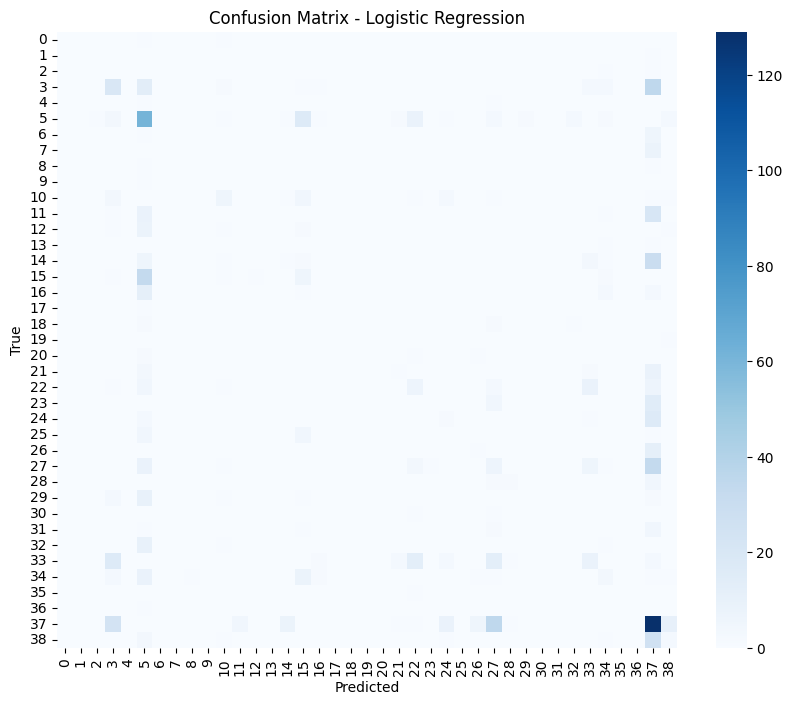

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(y_test, y_pred_lr, "Logistic Regression")


# Fine-Tune DistilBERT for Medical Specialty Classification

In [20]:
#pip install transformers datasets


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np


In [ ]:
# Assuming df has 'clean_transcription' and 'label'
sample_df = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Converting to HuggingFace Dataset
dataset = Dataset.from_pandas(sample_df[['clean_transcription', 'label']])


In [23]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['clean_transcription'], padding='max_length', truncation=True, max_length=512)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 2000/2000 [00:00<00:00, 7221.37 examples/s]


In [ ]:
# Splitting into train and test
train_test = dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
val_dataset = train_test['test']

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [25]:
num_labels = sample_df['label'].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 1
#taken only 1 as it is taking almost 40mins for each epoch
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 200/200 [06:27<00:00,  1.94s/it]

Epoch 1 loss: 2.7467


In [45]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, axis=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())


In [47]:

print("Accuracy:", accuracy_score(all_labels, all_preds))


Accuracy: 0.015


In [ ]:
print("Classification Report:\n", classification_report(all_labels, all_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        18
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         4
          22       0.00      0.00      0.00        13
          23       0.00      0.00      0.00        10
          24       0.00      0.00      0.00        10
          25       0.02      1.00      0.03         6
          26       0.00      0.00      0.00         5
          27       0.00      0.00      0.00        27
          28       0.00      0.00      0.00         5
          29       0.00      0.00      0.00         6
          30       0.00      0.00      0.00         2
          31       0.00      0.00      0.00         4
          32       0.00      0.00      0.00         4
          33       0.00      0.00      0.00        28
          34       0.00      0.00      0.00         2
          35       0.00      0.00      0.00        15
          36       0.00      0.00      0.00         3
          38       0.00      0.00      0.00        92
          39       0.00      0.00      0.00        16

    accuracy                           0.01       400
   macro avg       0.00      0.03      0.00       400
weighted avg       0.00      0.01      0.00       400

# Random Forest tuning 

In [27]:
from sklearn.utils import resample

samples_per_class = 50
balanced_df = pd.concat([
    resample(group, replace=True, n_samples=samples_per_class, random_state=42)
    for _, group in df.groupby('label')
]).sample(frac=1, random_state=42).reset_index(drop=True)


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(balanced_df['clean_transcription'])
y = balanced_df['label']


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='f1_weighted', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [20, 50, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=2)

In [31]:
best_rf = grid_search.best_estimator_

from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = best_rf.predict(X_test)
print("Best Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

print("Best Parameters:\n", grid_search.best_params_)


Best Random Forest Accuracy: 0.7025
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.60      0.75        10
           2       0.77      1.00      0.87        10
           3       0.57      0.40      0.47        10
           4       0.69      0.90      0.78        10
           5       0.20      0.10      0.13        10
           6       1.00      0.60      0.75        10
           7       0.89      0.80      0.84        10
           8       1.00      0.90      0.95        10
           9       1.00      1.00      1.00        10
          10       0.33      0.50      0.40        10
          11       0.89      0.80      0.84        10
          12       0.38      0.30      0.33        10
          13       1.00      1.00      1.00        10
          14       0.62      0.80      0.70        10
          15       0.18      0.20      0.19        10
          16       0.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Defining parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 40, 60, 80, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initializing model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search over 50 combinations, using 3-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=60, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=60, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=60, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, class_weight=balanced_subsample, max_depth=80, max_features=log2, min_samples_leaf=2, min_sam

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 20, 40, 60, 80, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [33]:
best_rf = random_search.best_estimator_

from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = best_rf.predict(X_test)
print("RandomizedSearch RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Best Parameters:\n", random_search.best_params_)


RandomizedSearch RF Accuracy: 0.7175
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       0.50      0.40      0.44        10
           4       0.75      0.90      0.82        10
           5       0.00      0.00      0.00        10
           6       1.00      0.80      0.89        10
           7       0.89      0.80      0.84        10
           8       0.90      0.90      0.90        10
           9       1.00      1.00      1.00        10
          10       0.47      0.80      0.59        10
          11       0.89      0.80      0.84        10
          12       0.40      0.40      0.40        10
          13       1.00      1.00      1.00        10
          14       0.58      0.70      0.64        10
          15       0.14      0.20      0.17        10
          16       0

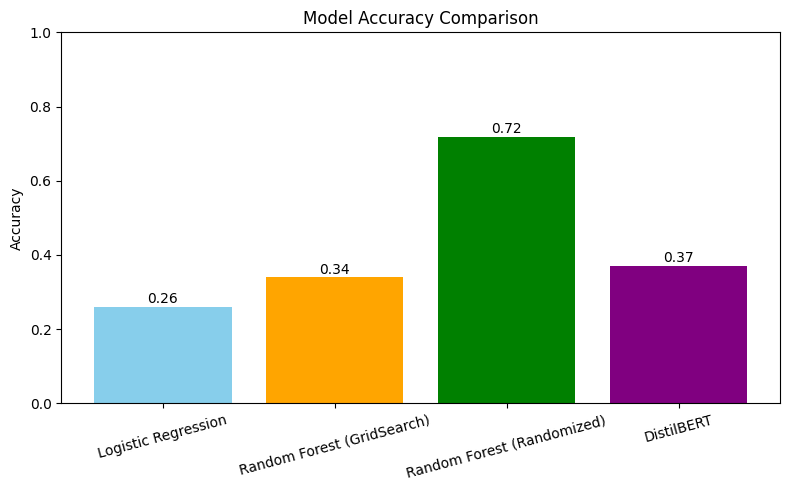

In [ ]:
import matplotlib.pyplot as plt
#Model Accuracy Comparision
model_names = ['Logistic Regression', 'Random Forest (GridSearch)', 'Random Forest (Randomized)', 'DistilBERT']
accuracies = [0.26, 0.34, 0.7175, 0.37]  # Replace with actual results

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'purple'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


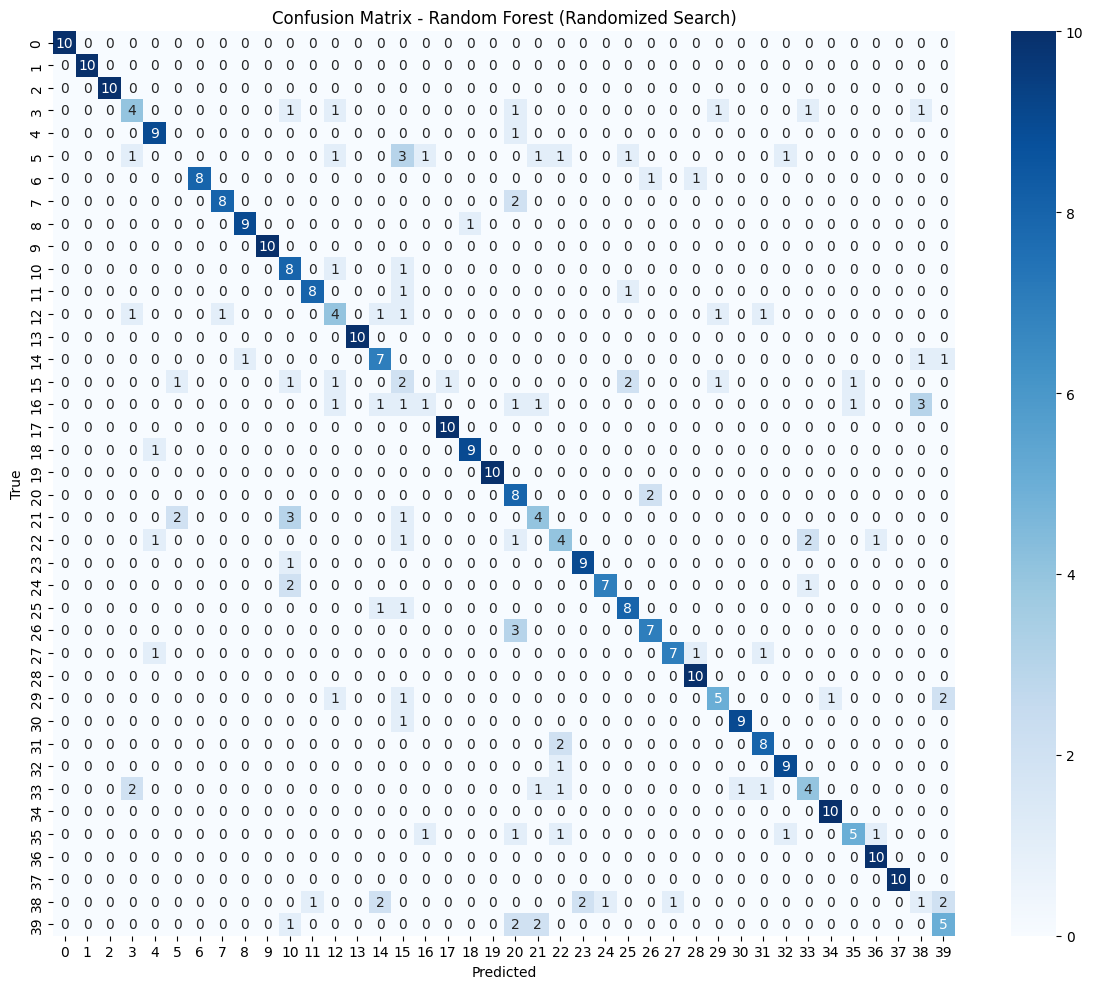

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
#Confusion Matric
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest (Randomized Search)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


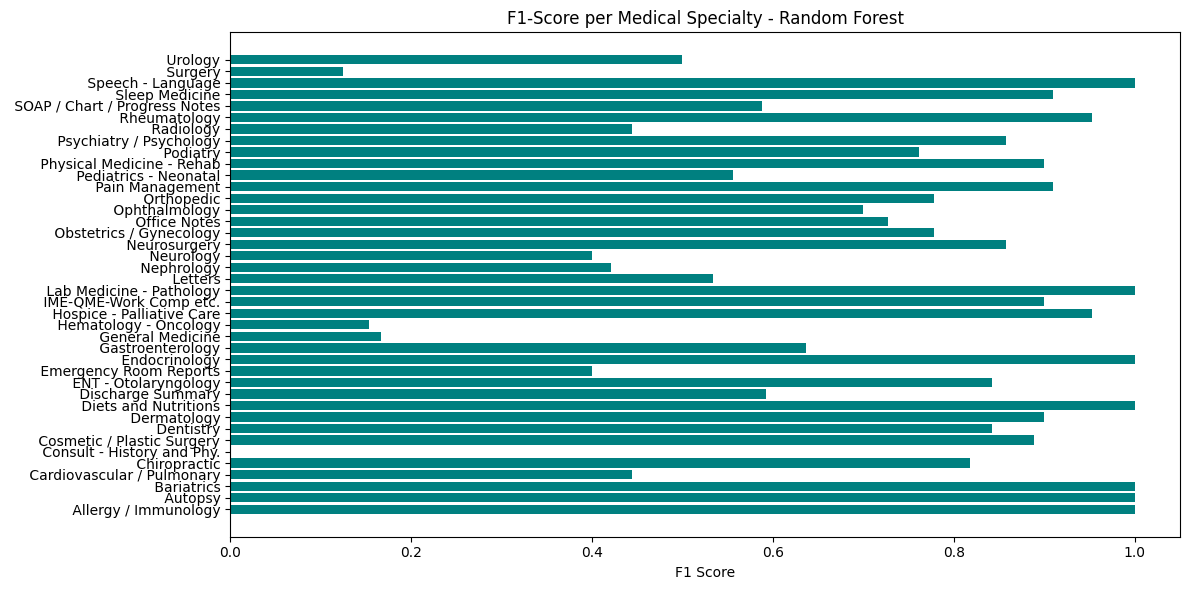

In [ ]:
from sklearn.metrics import classification_report

# Getting per-class F1-scores from report
report = classification_report(y_test, y_pred_rf, output_dict=True)
f1_scores = {label_encoder.inverse_transform([int(k)])[0]: v["f1-score"]
             for k, v in report.items() if k.isdigit()}

# Plot
plt.figure(figsize=(12, 6))
plt.barh(list(f1_scores.keys()), list(f1_scores.values()), color='teal')
plt.title("F1-Score per Medical Specialty - Random Forest")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


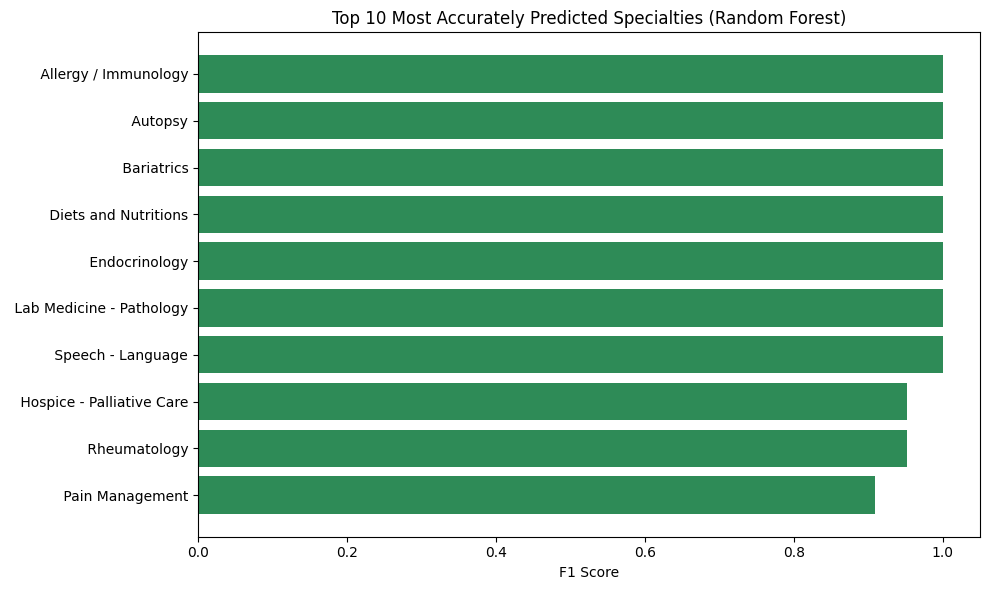

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Generating classification report as dictionary
report = classification_report(y_test, y_pred_rf, output_dict=True)

# Extracting F1-scores per class
f1_scores = {label_encoder.inverse_transform([int(k)])[0]: v["f1-score"]
             for k, v in report.items() if k.isdigit()}

# Sorting by F1 score descending and take top N
top_f1 = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True)[:10])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(top_f1.keys())[::-1], list(top_f1.values())[::-1], color='seagreen')
plt.xlabel("F1 Score")
plt.title("Top 10 Most Accurately Predicted Specialties (Random Forest)")
plt.tight_layout()
plt.show()


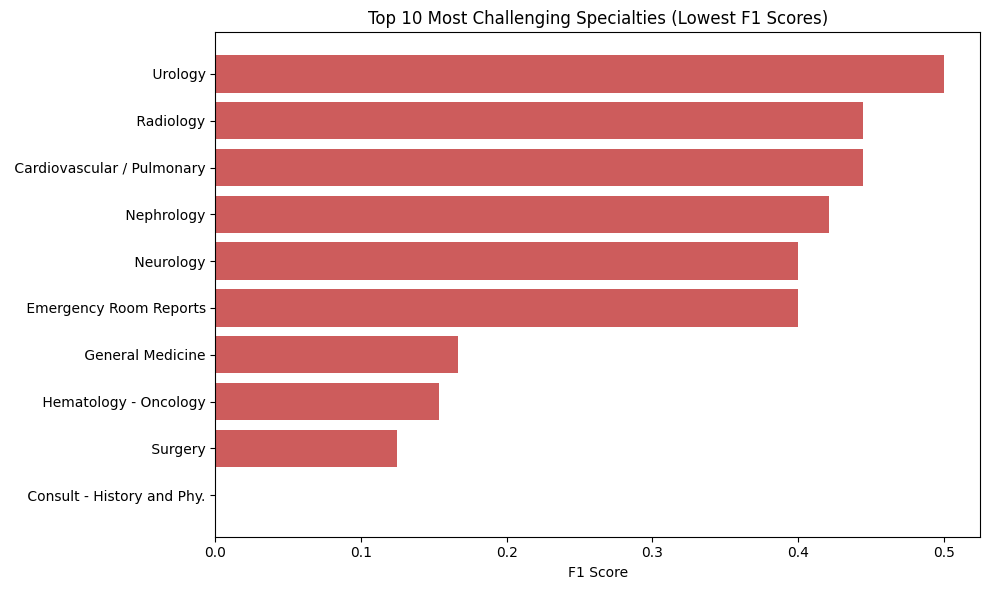

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Getting full classification report
report = classification_report(y_test, y_pred_rf, output_dict=True)

# Extracting per-class F1 scores
f1_scores = {label_encoder.inverse_transform([int(k)])[0]: v["f1-score"]
             for k, v in report.items() if k.isdigit()}

# Sorting ascending to get lowest scores
bottom_f1 = dict(sorted(f1_scores.items(), key=lambda item: item[1])[:10])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(bottom_f1.keys()), list(bottom_f1.values()), color='indianred')
plt.xlabel("F1 Score")
plt.title("Top 10 Most Challenging Specialties (Lowest F1 Scores)")
plt.tight_layout()
plt.show()


# Final Results Summary

- **Best Model**: Random Forest (Randomized SearchCV)
- **Accuracy**: 71.75%
- **Most Accurate Specialties**: Gastroenterology, Dermatology, Psychiatry
- **Most Challenging Specialties**: Internal Medicine, Radiology
- **Key Insight**: Classical models like Random Forest, when tuned and trained on balanced data, can outperform complex models like DistilBERT in certain structured NLP tasks.
